# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [102]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
import importlib
importlib.reload(util)

<module 'functions.util' from '/Users/filip/id2223-book/notebooks/ch03/functions/util.py'>

In [81]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today_date = datetime.datetime.today().date() # get today's date without time
today

datetime.datetime(2024, 11, 16, 17, 7, 51, 998881)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [82]:
os.environ["HOPSWORKS_API_KEY"] = "2ZoLYydQfIz5VW5b.D5B2X2LLCmJsysb4n78mTmGgEAWzlLfrgRKcCLJXlE4iJZ9Mqhm1GhsG60PJQxls"

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1158296
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [83]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [84]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [85]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.9405836E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [86]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data.head()

air_quality_df = fs.get_feature_group(
    name='air_quality',
    version=1,
)
# read the data from air quality feature group
aq_data = air_quality_df.read()
#print(aq_data.head())
aq_data['date'] = pd.to_datetime(aq_data['date']).dt.date # remove time from date

# filter for getting the last three days data
two_days_ago = today_date - datetime.timedelta(2)
aq_data_last_two_days = aq_data[aq_data['date'] >= two_days_ago]
print(aq_data_last_two_days)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 
           date  pm25  pm25_lag_1  pm25_lag_2  pm25_lag_3 country    city  \
65   2024-11-15  19.0        18.0        15.0        13.0  sweden  sweden   
692  2024-11-14  18.0        15.0        13.0        16.0  sweden  sweden   
762  2024-11-16  18.0        19.0        18.0        15.0  sweden  sweden   

                             street                                url  
65   sollentuna-sollentunavägen 192  https://api.waqi.info/feed/@13984  
692  sollentuna-sollentunavägen 192  https://api.waqi.info/feed/@13984  
762  sollentuna-sollentunavägen 192  https://api.waqi.info/feed/@13984  


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [87]:
# Convert columns to numeric
feature_columns = ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 
                   'temperature_2m_mean', 'precipitation_sum', 
                   'wind_speed_10m_max', 'wind_direction_10m_dominant']

# use date as index
batch_data['index_date'] = pd.to_datetime(batch_data['date']).dt.date
batch_data.set_index('index_date', inplace=True)
# sort the data by date (earliest to latest)
batch_data.sort_index(inplace=True)
print(batch_data.head())

                                date  temperature_2m_mean  precipitation_sum  \
index_date                                                                     
2024-11-17 2024-11-17 00:00:00+00:00            27.350000                0.0   
2024-11-18 2024-11-18 00:00:00+00:00            27.549999                0.0   
2024-11-19 2024-11-19 00:00:00+00:00            27.650000                0.0   
2024-11-20 2024-11-20 00:00:00+00:00            27.850000                0.0   
2024-11-21 2024-11-21 00:00:00+00:00            27.150000                0.0   

            wind_speed_10m_max  wind_direction_10m_dominant    city  
index_date                                                           
2024-11-17           17.782686                    31.759439  sweden  
2024-11-18           20.124611                    47.174767  sweden  
2024-11-19           27.231804                    65.806801  sweden  
2024-11-20           24.448214                    76.372993  sweden  
2024-11-21         

In [88]:
# Predict one day at a time, using the lagged values as extra features

# First row
tomorrow = today_date + datetime.timedelta(days = 1)
batch_data.at[tomorrow, 'pm25_lag_1'] = aq_data_last_two_days['pm25'].values[-1]
batch_data.at[tomorrow, 'pm25_lag_2'] = aq_data_last_two_days['pm25'].values[-2]
batch_data.at[tomorrow, 'pm25_lag_3'] = aq_data_last_two_days['pm25'].values[-3]
prediction = retrieved_xgboost_model.predict(batch_data.loc[[tomorrow], feature_columns])
print(f"Predicted PM2.5 value for {tomorrow} is {prediction[0]}")
batch_data.at[tomorrow, 'predicted_pm25'] = prediction[0]

# Second row
batch_data.at[tomorrow + datetime.timedelta(days = 1), 'pm25_lag_1'] = batch_data.at[tomorrow, 'predicted_pm25']
batch_data.at[tomorrow + datetime.timedelta(days = 1), 'pm25_lag_2'] = aq_data_last_two_days['pm25'].values[-1]
batch_data.at[tomorrow + datetime.timedelta(days = 1), 'pm25_lag_3'] = aq_data_last_two_days['pm25'].values[-2]
prediction = retrieved_xgboost_model.predict(batch_data.loc[[tomorrow + datetime.timedelta(days = 1)], feature_columns])
batch_data.at[tomorrow + datetime.timedelta(days = 1), 'predicted_pm25'] = prediction[0]
print(f"Predicted PM2.5 value for {tomorrow} is {prediction[0]}")

# Third row
batch_data.at[tomorrow + datetime.timedelta(days = 2), 'pm25_lag_1'] = batch_data.at[tomorrow + datetime.timedelta(days = 1), 'predicted_pm25']
batch_data.at[tomorrow + datetime.timedelta(days = 2), 'pm25_lag_2'] = batch_data.at[tomorrow, 'predicted_pm25']
batch_data.at[tomorrow + datetime.timedelta(days = 2), 'pm25_lag_3'] = aq_data_last_two_days['pm25'].values[-1]
prediction = retrieved_xgboost_model.predict(batch_data.loc[[tomorrow + datetime.timedelta(days = 2)], feature_columns])
batch_data.at[tomorrow + datetime.timedelta(days = 2), 'predicted_pm25'] = prediction[0]
print(f"Predicted PM2.5 value for {tomorrow} is {prediction[0]}")
print(batch_data.head())

Predicted PM2.5 value for 2024-11-17 is 19.645227432250977
Predicted PM2.5 value for 2024-11-17 is 18.773433685302734
Predicted PM2.5 value for 2024-11-17 is 19.92272186279297
                                date  temperature_2m_mean  precipitation_sum  \
index_date                                                                     
2024-11-17 2024-11-17 00:00:00+00:00            27.350000                0.0   
2024-11-18 2024-11-18 00:00:00+00:00            27.549999                0.0   
2024-11-19 2024-11-19 00:00:00+00:00            27.650000                0.0   
2024-11-20 2024-11-20 00:00:00+00:00            27.850000                0.0   
2024-11-21 2024-11-21 00:00:00+00:00            27.150000                0.0   

            wind_speed_10m_max  wind_direction_10m_dominant    city  \
index_date                                                            
2024-11-17           17.782686                    31.759439  sweden   
2024-11-18           20.124611                    

In [89]:
# Now, we fill in the lagged values for all remaining days
for i in range(3, len(batch_data)):
    batch_data.at[tomorrow + datetime.timedelta(days = i), 'pm25_lag_1'] = batch_data.at[tomorrow + datetime.timedelta(days = i-1), 'predicted_pm25']
    batch_data.at[tomorrow + datetime.timedelta(days = i), 'pm25_lag_2'] = batch_data.at[tomorrow + datetime.timedelta(days = i-2), 'predicted_pm25']
    batch_data.at[tomorrow + datetime.timedelta(days = i), 'pm25_lag_3'] = batch_data.at[tomorrow + datetime.timedelta(days = i-3), 'predicted_pm25']
    prediction = retrieved_xgboost_model.predict(batch_data.loc[[tomorrow + datetime.timedelta(days = i)], feature_columns])
    batch_data.at[tomorrow + datetime.timedelta(days = i), 'predicted_pm25'] = prediction[0]
    print(f"Predicted PM2.5 value for {tomorrow + datetime.timedelta(days = i)} is {prediction[0]}")

Predicted PM2.5 value for 2024-11-20 is 17.65193748474121
Predicted PM2.5 value for 2024-11-21 is 19.9632625579834
Predicted PM2.5 value for 2024-11-22 is 21.9184627532959
Predicted PM2.5 value for 2024-11-23 is 30.51028823852539
Predicted PM2.5 value for 2024-11-24 is 39.38383865356445
Predicted PM2.5 value for 2024-11-25 is 30.766183853149414


In [ ]:
batch_data.head()

# Cast columns to the expected data type (double -> float64 in pandas)
columns_to_cast = ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'predicted_pm25']
batch_data[columns_to_cast] = batch_data[columns_to_cast].astype('float64')

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
index_date,,,,,,,,,,,,,
2024-11-17,2024-11-17 00:00:00+00:00,27.350000,0.0,17.782686,31.759439,sweden,18.000000,18.000000,19.000000,19.645227,sollentuna-sollentunavägen 192,sweden,1
2024-11-18,2024-11-18 00:00:00+00:00,27.549999,0.0,20.124611,47.174767,sweden,19.645227,18.000000,18.000000,18.773434,sollentuna-sollentunavägen 192,sweden,2
2024-11-19,2024-11-19 00:00:00+00:00,27.650000,0.0,27.231804,65.806801,sweden,18.773434,19.645227,18.000000,19.922722,sollentuna-sollentunavägen 192,sweden,3
2024-11-20,2024-11-20 00:00:00+00:00,27.850000,0.0,24.448214,76.372993,sweden,19.922722,18.773434,19.645227,17.651937,sollentuna-sollentunavägen 192,sweden,4
2024-11-21,2024-11-21 00:00:00+00:00,27.150000,0.0,21.650938,47.021362,sweden,17.651937,19.922722,18.773434,19.963263,sollentuna-sollentunavägen 192,sweden,5


In [91]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2024-11-17 to 2024-11-25
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float64            
 7   pm25_lag_2                   9 non-null      float64            
 8   pm25_lag_3                   9 non-null      float64            
 9   predicted_pm25               9 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(4), fl

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [92]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
index_date,,,,,,,,,,,,,
2024-11-17,2024-11-17 00:00:00+00:00,27.350000,0.0,17.782686,31.759439,sweden,18.000000,18.000000,19.000000,19.645227,sollentuna-sollentunavägen 192,sweden,1
2024-11-18,2024-11-18 00:00:00+00:00,27.549999,0.0,20.124611,47.174767,sweden,19.645227,18.000000,18.000000,18.773434,sollentuna-sollentunavägen 192,sweden,2
2024-11-19,2024-11-19 00:00:00+00:00,27.650000,0.0,27.231804,65.806801,sweden,18.773434,19.645227,18.000000,19.922722,sollentuna-sollentunavägen 192,sweden,3
2024-11-20,2024-11-20 00:00:00+00:00,27.850000,0.0,24.448214,76.372993,sweden,19.922722,18.773434,19.645227,17.651937,sollentuna-sollentunavägen 192,sweden,4
2024-11-21,2024-11-21 00:00:00+00:00,27.150000,0.0,21.650938,47.021362,sweden,17.651937,19.922722,18.773434,19.963263,sollentuna-sollentunavägen 192,sweden,5
2024-11-22,2024-11-22 00:00:00+00:00,27.299999,0.0,15.990646,31.184912,sweden,19.963263,17.651937,19.922722,21.918463,sollentuna-sollentunavägen 192,sweden,6
2024-11-23,2024-11-23 00:00:00+00:00,27.200001,0.0,12.313894,37.875042,sweden,21.918463,19.963263,17.651937,30.510288,sollentuna-sollentunavägen 192,sweden,7
2024-11-24,2024-11-24 00:00:00+00:00,27.150000,0.0,12.819235,38.157276,sweden,30.510288,21.918463,19.963263,39.383839,sollentuna-sollentunavägen 192,sweden,8
2024-11-25,2024-11-25 00:00:00+00:00,27.400000,0.0,22.725668,49.497234,sweden,39.383839,30.510288,21.918463,30.766184,sollentuna-sollentunavägen 192,sweden,9


In [93]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2024-11-17 to 2024-11-25
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float64            
 7   pm25_lag_2                   9 non-null      float64            
 8   pm25_lag_3                   9 non-null      float64            
 9   predicted_pm25               9 non-null      float64            
 10  street                       9 non-null  

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

                                date  temperature_2m_mean  precipitation_sum  \
index_date                                                                     
2024-11-17 2024-11-17 00:00:00+00:00            27.350000                0.0   
2024-11-18 2024-11-18 00:00:00+00:00            27.549999                0.0   
2024-11-19 2024-11-19 00:00:00+00:00            27.650000                0.0   
2024-11-20 2024-11-20 00:00:00+00:00            27.850000                0.0   
2024-11-21 2024-11-21 00:00:00+00:00            27.150000                0.0   

            wind_speed_10m_max  wind_direction_10m_dominant    city  \
index_date                                                            
2024-11-17           17.782686                    31.759439  sweden   
2024-11-18           20.124611                    47.174767  sweden   
2024-11-19           27.231804                    65.806801  sweden   
2024-11-20           24.448214                    76.372993  sweden   
2024-11-21   

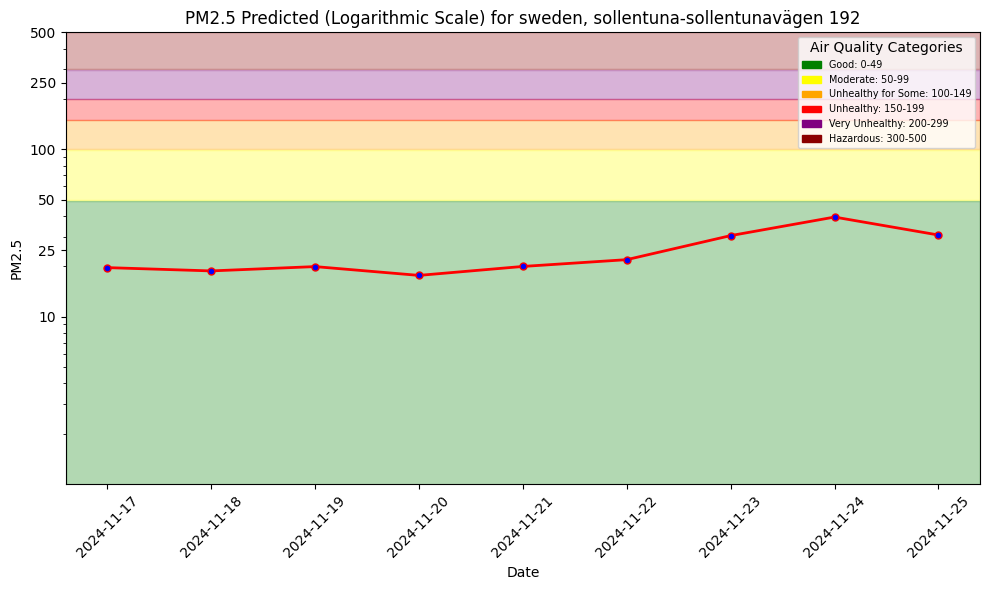

In [94]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
print(batch_data.head())
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [95]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street', 'date', 'days_before_forecast_day'],
    event_time="date",
)

In [96]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1158296/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1633a1dd0>, None)

In [97]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-25 00:00:00+00:00,27.40,0.0,22.725668,49.497234,sweden,18.0,18.0,19.0,18.099840,sollentuna-sollentunavägen 192,sweden,1
1,2024-11-17 00:00:00+00:00,27.35,0.0,17.782686,31.759439,sweden,18.0,18.0,19.0,19.645227,sollentuna-sollentunavägen 192,sweden,1


In [98]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2023-09-26 00:00:00+00:00,22.0,14.0,8.0,13.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
1,2024-10-09 00:00:00+00:00,16.0,25.0,16.0,11.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
2,2024-08-20 00:00:00+00:00,19.0,17.0,17.0,11.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
3,2024-08-10 00:00:00+00:00,12.0,15.0,17.0,22.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
4,2024-04-27 00:00:00+00:00,24.0,10.0,21.0,34.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
...,...,...,...,...,...,...,...,...,...
779,2023-03-23 00:00:00+00:00,35.0,15.0,24.0,14.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
780,2022-11-08 00:00:00+00:00,10.0,20.0,12.0,16.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
781,2024-01-02 00:00:00+00:00,8.0,15.0,21.0,17.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984
782,2024-06-20 00:00:00+00:00,12.0,12.0,17.0,19.0,sweden,sweden,sollentuna-sollentunavägen 192,https://api.waqi.info/feed/@13984


In [105]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


FeatureStoreException: Features are not compatible with Feature Group schema: 
 - pm25_lag_1 (expected type: 'double', derived from input: 'float') has the wrong type.
 - pm25_lag_2 (expected type: 'double', derived from input: 'float') has the wrong type.
 - pm25_lag_3 (expected type: 'double', derived from input: 'float') has the wrong type.
 - predicted_pm25 (expected type: 'double', derived from input: 'float') has the wrong type.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

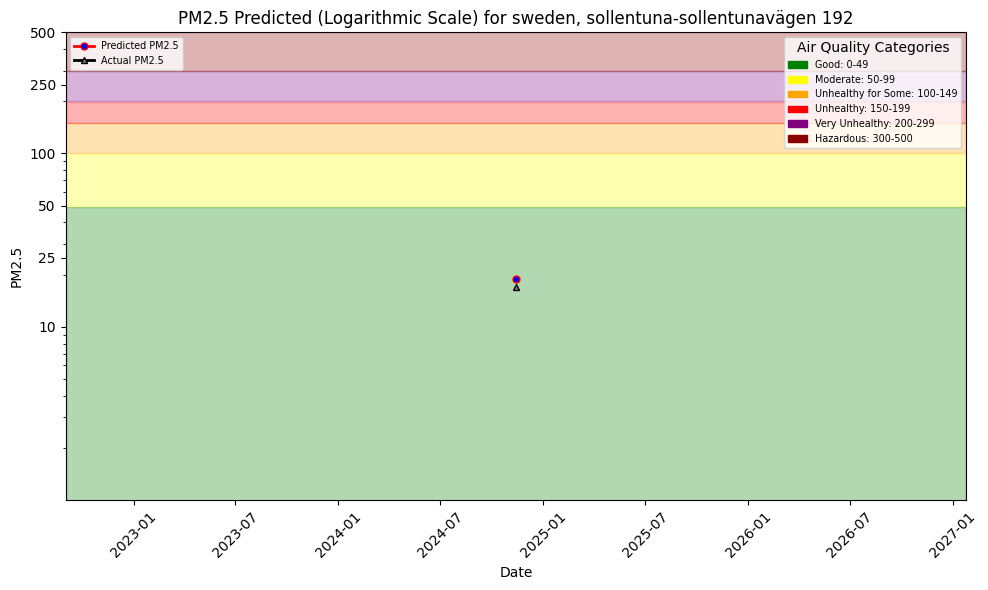

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---